<a href="https://colab.research.google.com/github/AroojArifNU/DLTest/blob/main/Colab_Notebooks/MNIST_GRAPH_Plot_2_properties_Abstarxct_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Model and Select Correct Examples**

In [2]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
print("Loading model...")
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')

# Load and preprocess the examples
print("Loading data...")
correct_examples = np.load('/content/drive/MyDrive/ColabNotebooks/correct_examples.npy')
correct_labels = np.load('/content/drive/MyDrive/ColabNotebooks/correct_labels.npy').astype('int32')

# Calculate accuracy on clean data
predictions = model.predict(correct_examples).argmax(axis=-1)
accuracy_clean = np.mean(predictions == correct_labels)
print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")

# Count the occurrences of each label in the test set
# Use numpy's unique function to find unique elements in the correct_labels array and their counts
unique, counts = np.unique(correct_labels, return_counts=True)

# Zip the unique labels and their counts into a dictionary for easy access and readability
correct_labels_counts = dict(zip(unique, counts))

# Print the occurrences of each label to the console, showing how many times each label appears
print("occurrences of each label:", correct_labels_counts)

for label, count in correct_labels_counts.items():
    print(f"Label {label}: {count}")

Loading model...
Loading data...
308/308 [==============================] - 1s 3ms/step
Accuracy on clean data: 99.60%
occurrences of each label: {0: 973, 1: 1133, 2: 1016, 3: 989, 4: 969, 5: 882, 6: 937, 7: 1005, 8: 946, 9: 984}
Label 0: 973
Label 1: 1133
Label 2: 1016
Label 3: 989
Label 4: 969
Label 5: 882
Label 6: 937
Label 7: 1005
Label 8: 946
Label 9: 984


In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               692352    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
________________________________________________


# **Select 250 samples in total at random and allocate them across classes 0 through 9.**

In [4]:
# Select a subset for demonstration


# Randomly select 250 unique indices from the range of the length of the correct_examples array without replacement
subset_indices = np.random.choice(range(len(correct_examples)), size=10, replace=False) #The parameter replace=False in the context of np.random.choice function means that once an item is selected from the array (or range) for inclusion in the sample, it cannot be selected again. This ensures that all elements in the resulting sample are unique, thereby preventing any duplicates. Essentially, it guarantees that the sampling is done without replacement.

# Use the selected indices to create a subset of images from the correct_examples array
subset_images = correct_examples[subset_indices]

# Similarly, use the selected indices to create a corresponding subset of labels from the correct_labels array
subset_labels = correct_labels[subset_indices]


In [5]:
# Use numpy's unique function to find all unique elements in the subset_labels array and count their occurrences
unique, counts = np.unique(subset_labels, return_counts=True)

# Combine the unique labels and their corresponding counts into a dictionary for easier access
subset_labels_counts = dict(zip(unique, counts))

# Print the dictionary containing the occurrences of each label in the subset
print("occurrences of each label:", subset_labels_counts)

# Iterate over the dictionary items (label and count pairs)
for label, count in subset_labels_counts.items():
    # Print each label and its count in a formatted string
    print(f"Label {label}: {count}")


occurrences of each label: {1: 1, 2: 3, 3: 1, 4: 1, 7: 2, 9: 2}
Label 1: 1
Label 2: 3
Label 3: 1
Label 4: 1
Label 7: 2
Label 9: 2


# **Automated Image Classification and Confidence Analysis**

In [6]:
import numpy as np
import tensorflow as tf

# Define a class named ImageTransformer
class ImageTransformer:
    # Initialize the ImageTransformer object with a model
    def __init__(self, model):
        self.model = model  # Store the provided model in an instance variable

    # Method to rotate an image by a specific number of degrees
    def rotate_image(self, image, degrees):
        # Rotate the image 90 degrees counter-clockwise, 'k' times, where 'k' is calculated from the degrees argument
        # 'degrees // 90' calculates how many times to rotate by 90 to achieve the desired rotation
        return tf.image.rot90(image, k=degrees // 90)

    # Method to adjust the brightness of an image
    def adjust_brightness(self, image, delta):
        # Adjust the brightness of the image using the delta value; positive delta brightens the image, negative delta darkens it
        return tf.image.adjust_brightness(image, delta)



    # Method to predict labels for a batch of images and calculate confidence scores
    def predict_with_confidence(self, images, actual_labels):
        # Use the stored model to predict the labels of the provided images
        predictions = self.model.predict(images)
        print("\n predictions:", predictions)

        # Calculate confidence scores for the predicted labels by finding the max prediction probability for each image
        confidence_scores_predicted = np.max(predictions, axis=1)
        print("\n confidence_scores_predicted:", confidence_scores_predicted)

        # Determine the predicted classes by finding the index (class label) with the highest prediction probability for each image
        predicted_classes = np.argmax(predictions, axis=1)
        print("\n predicted_classes:", predicted_classes)

        # Initialize a variable for confidence scores for actual classes; it will be used if actual_labels are provided
        confidence_scores_actual = None
        if actual_labels is not None:
            # If actual labels are provided, extract confidence scores for the actual classes by indexing the prediction probabilities
            confidence_scores_actual = predictions[np.arange(len(actual_labels)), actual_labels]
            print("\n confidence_scores_actual:", confidence_scores_actual)

        # Return the confidence scores for predicted classes, the predicted class labels, and confidence scores for actual classes (if provided)
        return confidence_scores_predicted, predicted_classes, confidence_scores_actual


In [15]:
from tabulate import tabulate
import numpy as np  # Used for numerical operations, especially converting lists to arrays

class RobustnessEvaluator:
    def __init__(self, transformer):
        # Initialize with a transformer (a model wrapper capable of applying transformations and making predictions)
        self.transformer = transformer
        self.sample_details = []  # List to hold details of each sample's evaluation

    def apply_transformation_and_predict(self, images, actual_labels, transformation_func, **kwargs):
        # Dynamically applies a specified image transformation and makes predictions on the transformed images

        # Determine which transformation function to apply based on its name
        if transformation_func.__name__ == 'rotate_image':
            # Apply rotation to each image in the batch
            transformed_images = [transformation_func(image, degrees=kwargs['degrees']) for image in images]
        elif transformation_func.__name__ == 'adjust_brightness':
            # Adjust brightness for each image in the batch
            transformed_images = [transformation_func(image, delta=kwargs['delta']) for image in images]
        else:
            # Raise error if transformation function is not supported
            raise ValueError("Unsupported transformation function.")

        # Convert the list of transformed images to a NumPy array for consistency
        transformed_images = np.array(transformed_images)
        # Use the transformer to predict classes and confidence scores for the transformed images
        confidence_scores, predicted_classes, confidence_scores_actual = self.transformer.predict_with_confidence(transformed_images, actual_labels)
        # Return the prediction results
        return confidence_scores, predicted_classes, actual_labels, confidence_scores_actual

    def evaluate(self, images, labels, properties):
        # Evaluates the model's robustness across specified transformations and settings
        for prop_name, settings in properties.items():  # Iterate over each transformation property
            for setting in settings:  # Iterate over settings for each property
                # Prepare arguments for the transformation function
                if prop_name == 'rotate_image':
                    kwargs = {'degrees': setting}
                    transformation_func = self.transformer.rotate_image
                elif prop_name == 'adjust_brightness':
                    kwargs = {'delta': setting}
                    transformation_func = self.transformer.adjust_brightness
                else:
                    # Skip unsupported properties
                    continue

                # Apply the transformation and predict
                confidence_scores, predicted_classes, actual_labels, confidence_scores_actual = self.apply_transformation_and_predict(images, labels, transformation_func, **kwargs)

                # Record detailed results for each sample
                for i, _ in enumerate(images):
                    self.sample_details.append({
                        'Property': prop_name,
                        'Setting': setting,
                        'Sample Index': i,
                        'Actual Label': labels[i],
                        'CS Actual Class': confidence_scores_actual[i],
                        'Predicted Class': predicted_classes[i],
                        'Confidence Score': confidence_scores[i]
                    })

    def display_results(self):
        # Convert sample details to DataFrame for display
        detailed_df = pd.DataFrame(self.sample_details)

        # Define robustness thresholds
        robustness_threshold = 0.85
        class_robustness_threshold = 0.85
        property_robustness_threshold = 0.85

        # Display detailed sample-wise results with robustness status
        print("Detailed Sample-wise Results with Robustness Status:")
        detailed_df['Robustness'] = detailed_df['CS Actual Class'].apply(lambda x: 'Robust' if x >= robustness_threshold else 'Not Robust')
        display(detailed_df)

        # Display aggregated class-wise confidence scores
        class_wise_df = detailed_df.groupby(['Property', 'Actual Label']).agg({'CS Actual Class': 'mean'}).reset_index()
        class_wise_df['Class Robustness'] = class_wise_df['CS Actual Class'].apply(lambda x: 'Robust' if x >= class_robustness_threshold else 'Not Robust')
        print("\nClass-wise Confidence with Robustness Status:")
        display(class_wise_df)

        # Display property-wise confidence and a combined confidence score
        prop_wise_df = detailed_df.groupby('Property').agg({'CS Actual Class': 'mean'}).reset_index()
        prop_wise_df['Property Robustness'] = prop_wise_df['CS Actual Class'].apply(lambda x: 'Robust' if x >= property_robustness_threshold else 'Not Robust')
        combined_confidence = np.prod(prop_wise_df['CS Actual Class'])
        combined_robustness = 'Robust' if combined_confidence >= property_robustness_threshold else 'Not Robust'
        prop_wise_df.loc[len(prop_wise_df.index)] = ['Combined', combined_confidence, combined_robustness]  # Include combined confidence and robustness
        print("\nProperty-wise and Combined Confidence with Robustness Status:")
        display(prop_wise_df)



In [16]:
import pandas as pd

# Set display options
pd.set_option('display.max_rows', None)  # Replace None with a specific number if needed
pd.set_option('display.max_columns', None)  # Replace None with a specific number if needed
pd.set_option('display.width', 1000)  # Adjust the width to fit your display
pd.set_option('display.max_colwidth', None)  # Adjust column width for better visibility


In [18]:
properties = {
    'rotate_image': [90],
    'adjust_brightness': [0.4],

}


# Load your pre-trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')
transformer = ImageTransformer(model)
evaluator = RobustnessEvaluator(transformer)


# Assuming subset_images and subset_labels are defined
evaluator.evaluate(subset_images, subset_labels, properties)
evaluator.display_results()

1/1 [==============================] - 0s 41ms/step

 predictions: [[2.7999383e-01 1.2981733e-03 7.2941760e-04 2.3903615e-06 5.1257383e-02
  7.0973235e-04 5.4209333e-05 5.7681441e-01 6.9923088e-04 8.8441186e-02]
 [1.6494757e-02 1.9484721e-08 1.0557388e-05 1.5058812e-04 2.2441368e-08
  9.8197055e-01 3.4998659e-06 2.0653861e-04 8.2866446e-04 3.3483098e-04]
 [5.9948200e-01 2.0438881e-08 1.9695706e-07 5.4155160e-09 4.1389189e-06
  4.2705204e-05 6.2634866e-04 3.9969507e-01 1.4937385e-04 1.5324119e-07]
 [4.4868723e-03 1.5609458e-10 2.3035254e-06 9.3265156e-09 1.1334590e-08
  9.9520850e-01 1.0670345e-05 4.0920580e-07 2.9020762e-04 9.6865620e-07]
 [9.8342871e-06 2.4504059e-09 5.3268018e-08 9.8387791e-12 9.9899614e-01
  1.4647499e-07 5.7288889e-09 8.8415708e-04 3.7012097e-07 1.0932261e-04]
 [1.1499466e-01 5.4392178e-04 1.8037197e-07 3.0894214e-04 1.3601664e-03
  5.7030275e-02 2.3081184e-06 4.8073703e-01 1.8529831e-01 1.5972427e-01]
 [4.8444335e-06 9.6766329e-01 1.3405057e-06 1.0077873e-06 1.317

,Property,Setting,Sample Index,Actual Label,CS Actual Class,Predicted Class,Confidence Score,Robustness
0,rotate_image,90.0,0,3,2.390361e-06,7,0.576814,Not Robust
1,rotate_image,90.0,1,9,3.348310e-04,5,0.981971,Not Robust
2,rotate_image,90.0,2,7,3.996951e-01,0,0.599482,Not Robust
3,rotate_image,90.0,3,7,4.092058e-07,5,0.995209,Not Robust
4,rotate_image,90.0,4,2,5.326802e-08,4,0.998996,Not Robust
5,rotate_image,90.0,5,2,1.803720e-07,7,0.480737,Not Robust
6,rotate_image,90.0,6,2,1.340506e-06,1,0.967663,Not Robust
7,rotate_image,90.0,7,1,4.465061e-06,7,0.991005,Not Robust
8,rotate_image,90.0,8,9,7.526102e-04,0,0.805839,Not Robust
9,rotate_image,90.0,9,4,3.948348e-04,2,0.610454,Not Robust



Class-wise Confidence with Robustness Status:


,Property,Actual Label,CS Actual Class,Class Robustness
0,adjust_brightness,1,9.935015e-01,Robust
1,adjust_brightness,2,6.675571e-01,Not Robust
2,adjust_brightness,3,9.886272e-01,Robust
3,adjust_brightness,4,9.999321e-01,Robust
4,adjust_brightness,7,5.871407e-01,Not Robust
5,adjust_brightness,9,9.893798e-01,Robust
6,rotate_image,1,4.465061e-06,Not Robust
7,rotate_image,2,5.247152e-07,Not Robust
8,rotate_image,3,2.390361e-06,Not Robust
9,rotate_image,4,3.948348e-04,Not Robust



Property-wise and Combined Confidence with Robustness Status:


,Property,CS Actual Class,Property Robustness
0,adjust_brightness,0.813777,Not Robust
1,rotate_image,0.040119,Not Robust
2,Combined,0.032648,Not Robust


from matplotlib import pyplot as plt
_df_0['CS Actual Class'].plot(kind='hist', bins=20, title='CS Actual Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Property').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['CS Actual Class'].plot(kind='line', figsize=(8, 4), title='CS Actual Class')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['Property'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='CS Actual Class', y='Property', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

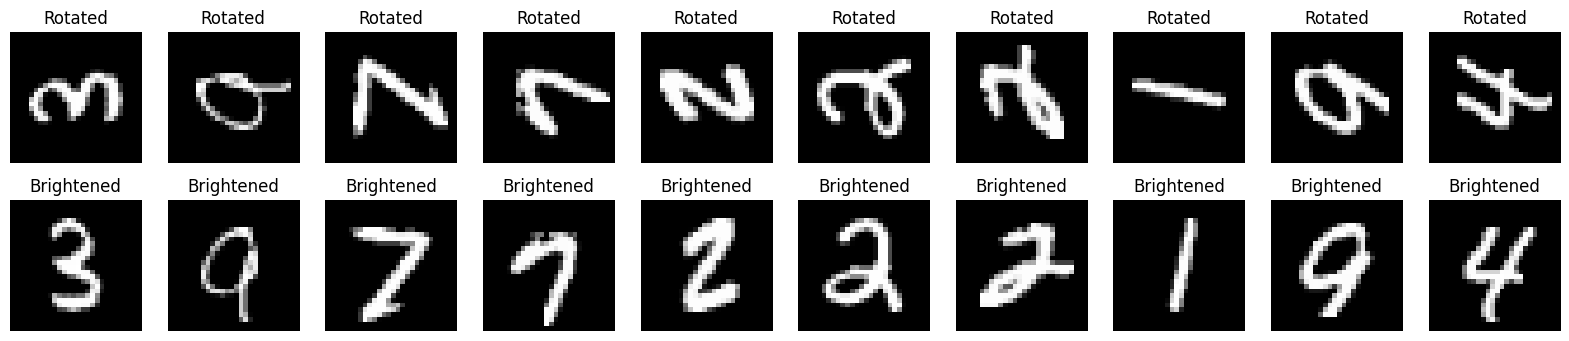

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Apply rotation transformation for the first property
rotated_images = np.array([transformer.rotate_image(image, degrees=90) for image in subset_images])

# Apply brightness adjustment for the second property
brightened_images = np.array([transformer.adjust_brightness(image, delta=0.9) for image in subset_images])

# Now, display the first 10 transformed images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(tf.squeeze(rotated_images[i]), cmap='gray')
    plt.title("Rotated")
    plt.axis('off')

    plt.subplot(2, 10, i + 11)
    plt.imshow(tf.squeeze(brightened_images[i]), cmap='gray')
    plt.title("Brightened")
    plt.axis('off')

plt.show()


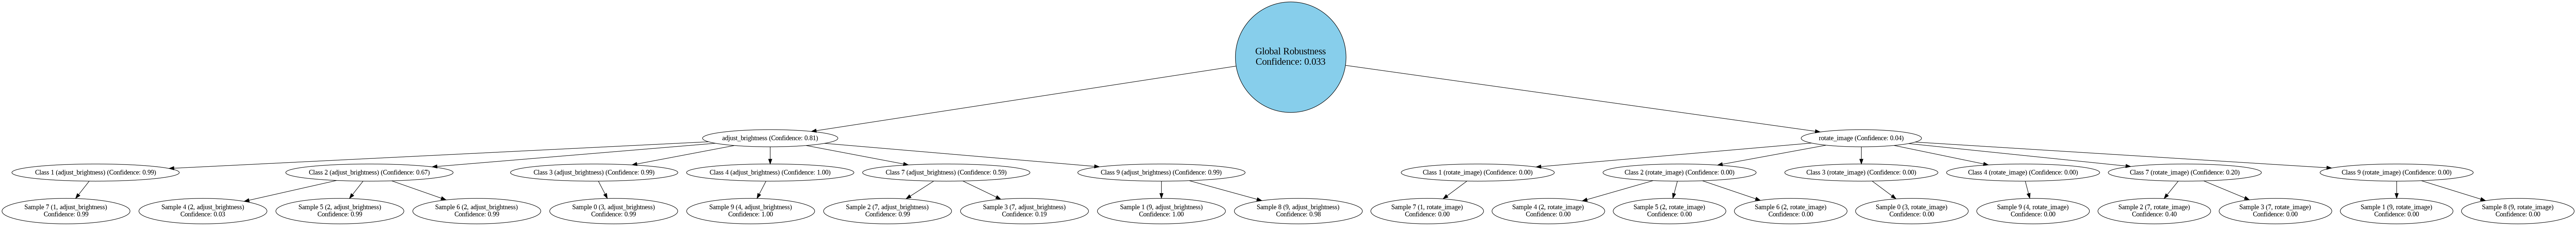

In [20]:

import pydot
from IPython.display import Image
import pandas as pd
import numpy as np

def generate_dynamic_tree(robustness_evaluator):
    # Converts the collected sample details from the robustness evaluation into a DataFrame for easier data manipulation
    detailed_df = pd.DataFrame(robustness_evaluator.sample_details)

    # Initializes a directed graph with top-to-bottom orientation using pydot
    graph = pydot.Dot(graph_type='digraph', rankdir='TB')

    # Creates a node representing the overall robustness of the model with a predefined style and color
    overall_robustness_node = pydot.Node(
        "Overall Robustness",
        label="Global Robustness",
        shape='circle',
        style="filled",
        fillcolor="skyblue",
        fontsize='20'
    )
    graph.add_node(overall_robustness_node)

    # Aggregates confidence scores by property and calculates a combined confidence score as the product of all property confidence scores
    property_confidence = detailed_df.groupby('Property')['CS Actual Class'].mean().reset_index()
    combined_confidence = property_confidence['CS Actual Class'].prod()

    # Updates the label of the overall robustness node to include the calculated combined confidence score
    overall_robustness_label = f"Global Robustness\nConfidence: {combined_confidence:.3f}"
    overall_robustness_node.set_label(overall_robustness_label)

    # Iterates through each property to create nodes and edges for the graph based on the evaluation data
    for property_name, prop_df in detailed_df.groupby('Property'):
        prop_mean_confidence = prop_df['CS Actual Class'].mean()
        prop_node_label = f"{property_name} (Confidence: {prop_mean_confidence:.2f})"
        prop_node = pydot.Node(prop_node_label, shape='ellipse', style="filled", fillcolor="lightgreen")
        graph.add_edge(pydot.Edge("Overall Robustness", prop_node_label))

        # For each class within a property, creates class nodes and connects them to their respective property node
        for class_label, class_df in prop_df.groupby('Actual Label'):
            class_mean_confidence = class_df['CS Actual Class'].mean()
            class_node_label = f"Class {class_label} ({property_name}) (Confidence: {class_mean_confidence:.2f})"
            class_node = pydot.Node(class_node_label, label=f"Class {class_label} (Confidence: {class_mean_confidence:.2f})", shape='circle', style="filled", fillcolor="lightyellow")
            graph.add_edge(pydot.Edge(prop_node_label, class_node_label))

            # Adds individual sample nodes under each class, including details like the sample index and confidence score
            for _, sample in class_df.iterrows():
                sample_node_label = f"Sample {sample['Sample Index']} ({class_label}, {property_name})\nConfidence: {sample['CS Actual Class']:.2f}"
                sample_node = pydot.Node(sample_node_label, shape='box', style="filled", fillcolor="lightgrey")
                graph.add_edge(pydot.Edge(class_node_label, sample_node_label))

    # Outputs the graph to a PNG file and returns an IPython Image object to display the graph inline in a Jupyter notebook
    output_file = 'dynamic_decision_tree_refined.png'
    graph.write_png(output_file)
    return Image(output_file)


# Assuming 'evaluator' is your instance of RobustnessEvaluator with evaluations completed
image = generate_dynamic_tree(evaluator)
display(image)


In [21]:
!pip install networkx pyvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


In [22]:
# Import necessary libraries for graph creation, data manipulation, and displaying the interactive visualization
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
from IPython.display import FileLink

def create_interactive_tree(robustness_evaluator):
    # Convert the sample details collected by the robustness evaluator into a DataFrame for easier processing
    detailed_df = pd.DataFrame(robustness_evaluator.sample_details)

    # Initialize a directed graph using NetworkX
    G = nx.DiGraph()

    # Create a node representing the overall robustness of the model
    overall_robustness_id = "Overall Robustness"
    G.add_node(overall_robustness_id, label="Global Robustness", shape='circle', color="skyblue")

    # Aggregate confidence scores by property from the evaluator's data and calculate a combined confidence score
    property_confidence = detailed_df.groupby('Property')['CS Actual Class'].mean().reset_index()
    combined_confidence = property_confidence['CS Actual Class'].prod()

    # Update the label of the overall robustness node to include the calculated combined confidence score
    G.nodes[overall_robustness_id]['label'] = f"Global Robustness\nConfidence: {combined_confidence:.3f}"

    # Iterate through each property to create nodes for properties and classes, adding them to the graph
    for property_name, prop_df in detailed_df.groupby('Property'):
        prop_mean_confidence = prop_df['CS Actual Class'].mean()
        prop_node_id = f"{property_name}"

        # Create a node for each property with its mean confidence score
        G.add_node(prop_node_id, label=f" Property:{property_name} (Confidence: {prop_mean_confidence:.2f})", color="lightgreen")
        # Connect the property node to the overall robustness node
        G.add_edge(overall_robustness_id, prop_node_id)

        # For each class within a property, create nodes and connect them to their respective property node
        for class_label, class_df in prop_df.groupby('Actual Label'):
            class_mean_confidence = class_df['CS Actual Class'].mean()
            class_node_id = f"Class {class_label} ({property_name})"
            # Create a node for each class with its mean confidence score
            G.add_node(class_node_id, label=f"Class {class_label} (Confidence: {class_mean_confidence:.2f})", color="yellow")
            # Connect the class node to its property node
            G.add_edge(prop_node_id, class_node_id)

            # Add individual sample nodes under each class with their confidence scores
            for i, sample in class_df.iterrows():
                sample_node_id = f"Sample {sample['Sample Index']} ({class_label}, {property_name})"
                # Create a node for each sample
                G.add_node(sample_node_id, label=f"S{sample['Sample Index']} (Confidence: {sample['CS Actual Class']:.2f})", color="grey")
                # Connect the sample node to its class node
                G.add_edge(class_node_id, sample_node_id)

    # Convert the NetworkX graph to a PyVis network for interactive visualization
    net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='in_line')
    net.from_nx(G)

    # Save the interactive visualization to an HTML file
    output_filepath = 'robustness_tree.html'
    net.save_graph('robustness_tree.html')

    # Return the file path to the saved HTML file for accessing or linking
    return output_filepath

# Example usage of the function, assuming an instance of RobustnessEvaluator named 'evaluator'
interactive_tree = create_interactive_tree(evaluator)
# Display a link to the generated HTML file containing the interactive visualization
display(FileLink(interactive_tree))


/content/robustness_tree.html

In [169]:
from IPython.display import IFrame

# Assuming the HTML file is saved in the current directory of the Jupyter notebook
IFrame(src='robustness_tree.html', width=700, height=600)
